In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl/examples`


In [2]:
using Revise, Adapt, CMBLensing, CMBLensingInferenceTestProblem, CUDA, JLD2, LaTeXStrings, LinearAlgebra, 
    MCMCChains, MCMCDiagnosticTools, MicroCanonicalHMC, MuseInference, MuseInference, Plots, 
    ProgressMeter, Random, Statistics, Zygote

In [3]:
Nside = 64
T = Float64;

In [4]:
prob = load_cmb_lensing_problem(;storage=Array, T, Nside, masking=true)

CMBLensingInferenceTestProblem.CMBLensingLogDensityProblem(BaseDataSet(d, Cf, Cn, Cn̂, M, M̂, B, B̂, logprior, Cϕ, Cf̃, D, G, L, Nϕ), [1.3165254752579545, 0.317726015830169, 0.38097848717317034, 1.1264968452151463, 1.7532435085739801, 1.7875455833816007, 1.4884964881077174, 1.2159107879104232, 0.7801812504355051, 0.1656272495264498  …  6.655664515936778e-6, 6.644649528795461e-6, 6.583241346168357e-6, 6.4746488802074385e-6, 6.3226791767313565e-6, 6.13143081921421e-6, 5.905071918532262e-6, 5.647741699346474e-6, -1.6094379124341003, 0.0], [2.724618244144275, 5.701545602758311, 6.232791145397454, 4.1762245565361615, 2.4523960863101597, 1.283220375835549, 4.552563432957781, 5.6307520506020605, 1.808110205693597, 1.091503117007472  …  3.0366415140559316e-6, 3.041742105491268e-6, 2.9464643630224668e-6, 2.755267330805766e-6, 2.456681142897097e-6, 2.0411912158742664e-6, 1.5252173910335987e-6, 9.95506314922585e-7, -1.6094379124341003, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 2.64100997670433 … 0.0 0.0; … ;

In [5]:
function get_mask_distance(prob)
    prob.ds.M isa LazyBinaryOp || error("masking must be enabled")
    mx = diag(prob.ds.M[2])[:Qx] .== 1;
    nearest = getfield.(@eval(CMBLensing,@ondemand(ImageMorphology.feature_transform))(mx), :I)
    Ny, Nx = size(mx)
    return [norm(nearest[i,j] .- [i,j]) for i=1:Ny,j=1:Nx]
end

get_mask_distance (generic function with 1 method)

In [6]:
dist_mat = get_mask_distance(prob)
dist_matt = exp.(-1.0 .* dist_mat)
threshold = 0.1
dist_matt[dist_matt .< threshold] .= threshold;

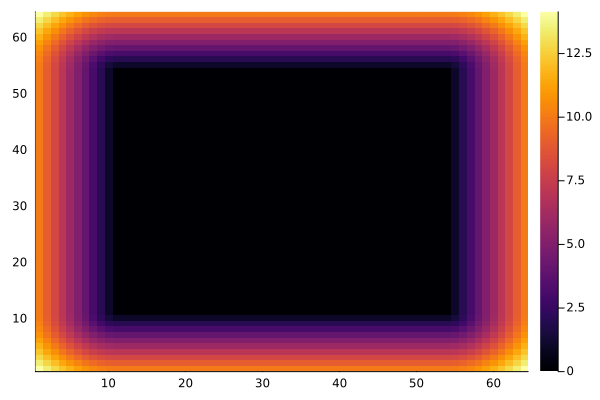

In [7]:
heatmap(dist_mat)

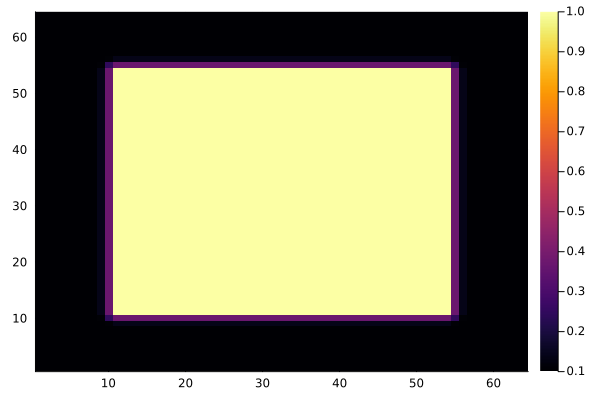

In [8]:
heatmap(dist_matt)

In [12]:
dist_mat_precond = [vec(dist_matt); vec(dist_matt); ones(64*64+2)];

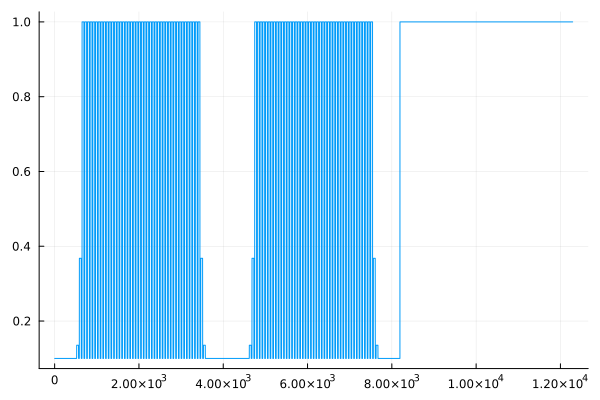

In [13]:
plot(dist_mat_precond, label=nothing)

In [14]:
@save "../chains/pixel_preconditioners/pp_nside_64" dist_mat_precond